In [1]:
import sys
import torch
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../src/')
from _97_gpytorch import LogisticGPVI, PGLikelihood
from _02_method import LogisticVI, KL_mvn
import _02_method 

%load_ext autoreload
%autoreload 2

In [2]:
dat = pd.read_csv("../data/data_add_std_fillNaNs.csv") 
dat.head()
dat.describe()
dat.groupby("earthquake").count()
dat.shape
dat.columns

Index(['Unnamed: 0', 'lon', 'lat', 'liq', 'earthquake', 'mw', 'PGV', 'PGA',
       'elev', 'slope', 'Vs30', 'vs_srtm', 'CTI', 'wtd', 'dc', 'dr', 'dr_2',
       'dw', 'dw_2', 'hwater', 'precip', 'AI', 'ai_cat', 'TPI', 'TRI', 'rough',
       'grp', 'PGV_std', 'lnPGV', 'lnVs30', 'lnprecip', 'lndc', 'lndr',
       'lndcdr', 'lndw', 'lnwtd'],
      dtype='object')

In [3]:
y = dat.liq
# X = dat[["PGV", "Vs30", "precip", "dw", "wtd"]]
X = dat[['lnPGV', 'lnVs30', 'lnprecip','lndw', 'lnwtd']]

In [4]:
# train on piedmontA
quake = "lomaprieta1989"
X_train = X[dat.earthquake != quake]
y_train = y[dat.earthquake != quake]
X_test =  X[dat.earthquake == quake]
y_test =  y[dat.earthquake == quake]


In [5]:
X_train
y_train.value_counts()

liq
0    1217650
1     501750
Name: count, dtype: int64

In [6]:
X_train = torch.tensor(X_train.values, dtype=torch.double)
y_train = torch.tensor(y_train.values, dtype=torch.double)

X_m = torch.mean(X_train, dim=0)
X_train = (X_train - X_m) 


X_test = torch.tensor(X_test.values, dtype=torch.double)
X_test = (X_test - X_m)
y_test = torch.tensor(y_test.values, dtype=torch.double)

In [7]:
# load the models
f0 = torch.load("../results/application/f0.pt")
f1 = torch.load("../results/application/f1.pt")
f2 = torch.load("../results/application/f2.pt")
f3 = torch.load("../results/application/f3.pt")
f4 = torch.load("../results/application/f4.pt")
f5 = torch.load("../results/application/f5.pt")

In [8]:
torch.manual_seed(1)

b0 = f0.sample(1000)
b1 = f1.sample(1000)
b2 = f2.sample(1000)
b3 = f3.sample(1000)
b4 = f4.sample(1000)
b5 = f5.sample(1000)


X_test_i = torch.cat((torch.ones(X_test.shape[0],1), X_test), dim=1)
preds0 = torch.sigmoid(X_test_i @ b0.T).std(dim=1)
preds1 = torch.sigmoid(X_test_i @ b1.T).std(dim=1)
preds2 = torch.sigmoid(X_test_i @ b2.T).std(dim=1)
preds3 = torch.sigmoid(X_test_i @ b3.T).std(dim=1)
preds4 = torch.sigmoid(X_test_i @ b4.T).std(dim=1)
preds5 = torch.sigmoid(X_test_i @ b5.T).std(dim=1)

# preds0 = preds0 - preds2
# preds1 = preds1 - preds3

In [9]:
quake = "lomaprieta1989"
loma = dat[dat.earthquake == quake]

In [10]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import cascaded_union

geometry = [Point(xy) for xy in zip(loma.lon, loma.lat)]
# sf = gpd.read_file("../data/cal/CA_Places_TIGER2016.shp")
gdf = gpd.GeoDataFrame(loma, geometry=geometry)
bodies_of_water = gpd.read_file("../data/map/qh320kj0191.shp")
bodies_of_water = bodies_of_water.to_crs(epsg=4326)
land_border = gpd.read_file("../data/map/s7d02x.shp")
counties = gpd.read_file("../data/map/s7hs4j.shp")
counties = counties.to_crs(epsg=4326)

In [11]:
# rasterize the points
gdf_copy = gdf.copy()

gdf_copy["preds0"] = preds0.detach().numpy()
gdf_copy["preds1"] = preds1.detach().numpy()
gdf_copy["preds2"] = preds2.detach().numpy()
gdf_copy["preds3"] = preds3.detach().numpy()
gdf_copy["preds4"] = preds4.detach().numpy()
gdf_copy["preds5"] = preds5.detach().numpy()

gdf_copy['geometry'] = gdf_copy.geometry.buffer(0.003)
gdf_copy = gdf_copy.dissolve(by="preds0")
gdf_copy = gdf_copy.reset_index()
gdf_copy = gdf_copy[["preds0", "preds1", "preds2", "preds3", "preds4", "preds5", 'geometry']]
gdf_copy = gdf_copy.set_geometry('geometry')

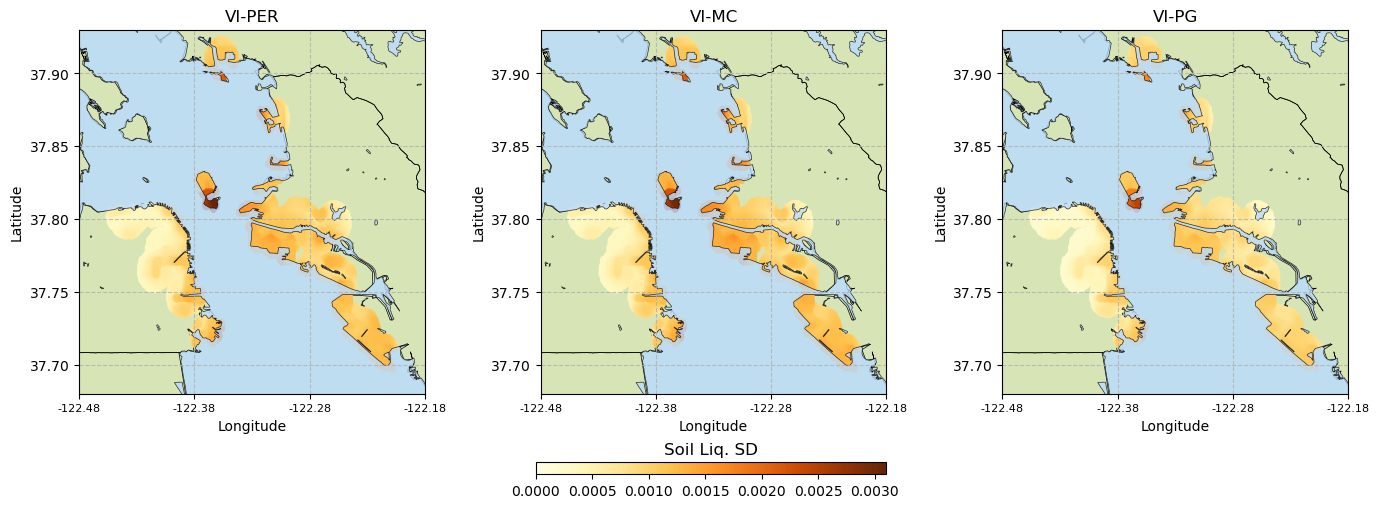

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4.0))

# use the same color scale for all plots
method_title = ["VI-PER", "VI-PER", "VI-PG", "VI-PG", "VI-MC", "VI-MC"]

vmin = 0
# vmax = max(gdf_copy.preds0.max(), gdf_copy.preds2.max(), gdf_copy.preds4.max())
vmax = max(gdf_copy.preds1.max(), gdf_copy.preds3.max(), gdf_copy.preds5.max())

for i, method  in enumerate([1, 5, 3]):
# for i, method  in enumerate([0, 4, 2]):
    # land_border.plot(ax=ax[i], color='lightgrey')
    land_border.plot(ax=ax[i], color='#cddfa4', alpha=0.8)
    counties.plot(ax=ax[i], edgecolor='black', linewidth=0.5, color='none')
    # gdf_copy.plot(ax=ax[i], column="preds{}".format(i), legend=(i == 3), alpha=0.5)
    gdf_copy.plot(ax=ax[i], column="preds{}".format(method), alpha=0.8, vmin=vmin, vmax=vmax, cmap='YlOrBr')
    
    bodies_of_water.plot(ax=ax[i], color='#badbff', edgecolor='black', linewidth=0.5, alpha=0.8)
    ax[i].set_title(method_title[method])
    ax[i].set_ylim([37.68, 37.93])
    ax[i].set_ylabel("Latitude")
    ax[i].grid(True, linestyle='--', alpha=0.8)
    ax[i].set_xlabel("Longitude")
    ax[i].set_xlim([-122.48, -122.18])
    ax[i].set_xticks([-122.48, -122.38, -122.28, -122.18])
    ax[i].set_xticklabels(["-122.48", "-122.38", "-122.28", "-122.18"], fontsize=8)
    
fig.tight_layout()
    
# add the colorbar to the side 
fig.subplots_adjust(bottom=0.001)
cax = fig.add_axes([0.39, -0.20, 0.25, 0.03])
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='horizontal')
cax.set_title("Soil Liq. SD")

# cax = fig.add_axes([0.92, 0.08, 0.01, 0.7])
# fig.colorbar(sm, cax=cax, orientation='vertical')


# plt.savefig("../../papers/logistic_vb/figures/lomaprieta1989.png", dpi=300, bbox_inches='tight') 
plt.savefig("../../papers/logistic_vb/figures/lomaprieta1989_full_Q.png", dpi=300, bbox_inches='tight') 

In [48]:
d1 = torch.distributions.MultivariateNormal(f1.m, f1.S)
d2 = torch.distributions.MultivariateNormal(f3.m, f3.S)
d3 = torch.distributions.MultivariateNormal(f5.m, f5.S)

torch.distributions.kl.kl_divergence(d3, d1)
torch.distributions.kl.kl_divergence(d3, d2)

tensor(4.8244, dtype=torch.float64, grad_fn=<AddBackward0>)